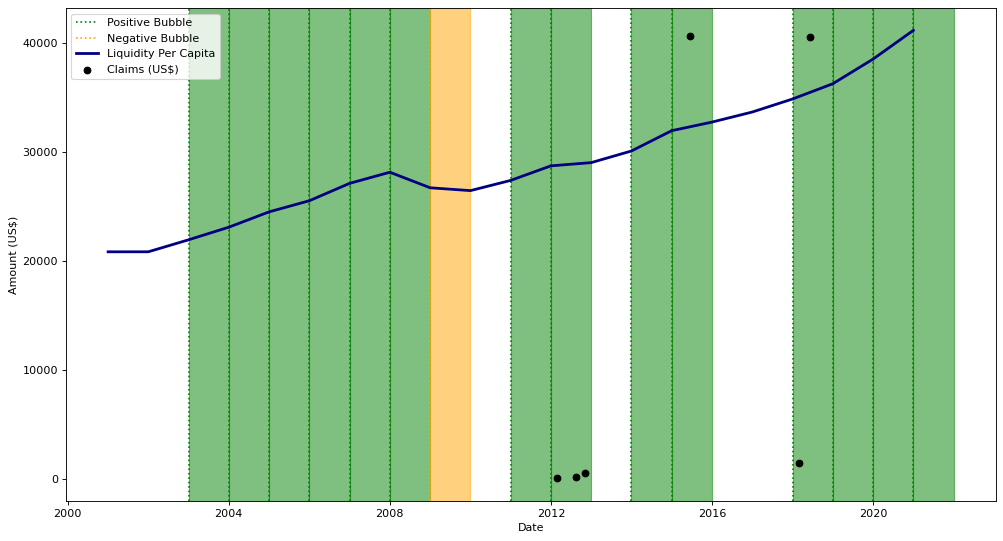

1.0

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fredapi import Fred
import datetime
import pandas_datareader as pdr

from pandas_datareader.data import DataReader
from matplotlib.pyplot import figure

from sklearn.impute import KNNImputer
%matplotlib inline

codes = pd.DataFrame(pd.read_excel(r"C:\Users\abhunia\OneDrive - Great American Insurance Group\Desktop\County_codes.xlsx"))

state_name = "Alabama" #Mention State Parameter
county_name = "Autauga County" #Mention County Parameter

state_data = codes.loc[codes["State_name"] == state_name]

y = np.array(state_data["Per_capita_Personal_income"])[list(np.array(state_data["County_name"])).index(county_name)] #input parameter for Local GDP
w = np.array(state_data["Unemployment_rate"])[list(np.array(state_data["County_name"])).index(county_name)] #input parameter for local unemployment rates
z = np.array(state_data["FIPS_Code"])[list(np.array(state_data["County_name"])).index(county_name)]  #input parameter for debt-to-income ratio
tol_rate = 0.02 #Should not be negative, currently at 200 basis points

#Put the debt to income ratio link: 
data1=pd.DataFrame(pd.read_excel(r"C:\Users\abhunia\OneDrive - Great American Insurance Group\Desktop\debt_by_county.xlsx"))
imputer = KNNImputer(n_neighbors=6)
data1 = imputer.fit_transform(data1)
data1 = pd.DataFrame(data1)
data1=data1.rename(columns={0:"Year",1: "qtr",2:"area_fips",3:"low",4:"high"})
data1 = data1.astype({"Year":"int","qtr":"int","area_fips":"int"})
data1 = data1.set_index("Year") 
#data_querying
#debt to income ratio
fips_code = z
indexes = np.where(np.array(data1["area_fips"] == fips_code))[0]
data1 = data1.iloc[indexes]
data1 = data1[["area_fips","high"]]
data1 = data1[2:]
data1 = data1[:len(data1)-1] #prepped debt to income ratio

#Unemployment Data (FRED)
start = datetime.datetime(2001,1,1)
end = datetime.datetime.now()

data2 = pdr.DataReader(w, "fred", start=start, end=end)
a= len(data2)
b=1+len(data2)/12
b=int(b)

jax = np.linspace(0,a,b)
jax = jax[:len(jax)-1]

data2 = data2.iloc[jax]
data2 = data2[:len(data2)-1]

#GDP Data (FRED)
data3 = pdr.DataReader(y,"fred",start=start,end=end)

#Liquidity Calculation

d2i_ratio = np.array(data1["high"])
unemployment_percent = np.array(data2[w])/100
per_capita_income = np.array(data3[y])
loan_30yr_pay = (d2i_ratio*per_capita_income)/30

liquidity = (per_capita_income - loan_30yr_pay)*(1-unemployment_percent) + (-loan_30yr_pay)*unemployment_percent
first=pd.DataFrame(liquidity)
second=pd.DataFrame(data2.index)
liquidity_df=pd.concat([first,second],axis=1).set_index("DATE")

#Claims Data Prep

claims_data= pd.DataFrame(pd.read_excel(r"C:\Users\abhunia\OneDrive - Great American Insurance Group\Desktop\Data_claims.xlsx"))
county_fips_code = z #input parameter

indexes2 = np.where(np.array(claims_data["CHOSEN_COUNTY_FIPS"] == county_fips_code))[0]

cl_df=claims_data.iloc[indexes2]
cl_df1=cl_df[["RPT_DATE","LOB","TOTAL_INCURRED"]]


#natural growth rate

natural_growth_rate = np.mean(np.array(data3[y].pct_change().dropna()))
nat1 = natural_growth_rate*(1+tol_rate)
nat2 = natural_growth_rate*(1-tol_rate)
df1 = np.array(pd.DataFrame(liquidity).pct_change().dropna()).reshape((len(np.array(pd.DataFrame(liquidity).pct_change().dropna()))))


#Positive Bubble

a = df1 > nat1
pos_points = np.where(a == True)[0]+1
pos_points = pos_points.astype(np.int32)

#Negative Bubble

b = -nat2 > df1
neg_points = np.where(b == True)[0]+1
neg_points = neg_points.astype(np.int32)

#Plotting the Graph
figure(figsize=(15,8),dpi=80)

list1 = []

for i in pos_points:
    pos_date_vals = np.array(data3[y].index)[i]
    list1.append(pos_date_vals)
    
list3 = []

for i in pos_points:
    pos_date_vals = np.array(data3[y].index)[i]
    list3.append(pos_date_vals)

list4 = []

for j in neg_points:
    neg_date_vals =  np.array(data3[y].index)[j]
    list4.append(neg_date_vals)
    
my_label1="Positive Bubble"

for xd in list3:
    plt.axvline(x=xd,color = "green", linestyle = ":",label = my_label1)
    my_label2 = "_nolegend_"
    
my_label2= "Negative Bubble"

for xu in list4:
    plt.axvline(x=xu,color = "orange", linestyle = ":",label = my_label2)
    my_label2 = "_nolegend_"

ga = pd.DatetimeIndex(list3)
ga1 = pd.DatetimeIndex(list3) + datetime.timedelta(365)

ha = pd.DatetimeIndex(list4)
ha1 = pd.DatetimeIndex(list4) + datetime.timedelta(365)

for i in np.arange(0,len(list3)):
    plt.axvspan(ga[i],ga1[i],alpha = 0.5, color = "green")

for j in np.arange(0,len(list4)):
    plt.axvspan(ha[j],ha1[j], alpha = 0.5, color = "orange")
    
plt.plot(liquidity_df,color = "navy", label="Liquidity Per Capita", linewidth =2.5)
plt.scatter(cl_df1["RPT_DATE"],cl_df1["TOTAL_INCURRED"],color="black", label="Claims (US$)")

plt.xlabel("Date")
plt.ylabel("Amount (US$)")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

# Accuracy Calculation

one = []

for i in cl_df1["RPT_DATE"]:
    one.append(i)

two = []
for i in list(np.arange(0,len(one))):
    two.append(one[i].year)


three = []
for i in np.arange(0,len(ga)):
    ga1=ga[i]
    three.append(ga1)

four = []
for i in list(np.arange(0,len(three))):
    four.append(three[i].year)

five = []
for i in np.arange(0,len(ha)):
    ha1 = ha[i]
    five.append(ha)
    
six = []
for i in list(np.arange(0,len(five))):
    six.append(five[i].year)

    
two = np.array(two)
four = np.array(four)
six = np.array(six)

count = 0
for i in two:
    if i in four:
        count +=1
    elif i in six:
        count +=1
  

    #Accuracy Rates

accuracy = count/len(one)
accuracy